# Starting with tensorflow and keras(uses tensorflow, MxNet and other deep learning library as a backend).

In short it is a library to generate/build a computation graph.
 - One writes codes to specify abstract computation like addition and matrix multiplication
 - One can feed the actual data later to evaluate different nodes in the graph.

# But Why to build graph for doing computations?
Building graph before doing actual computation provides lot of optimization benefits like
- Common Subexpression Elimination. Avoids redundant computation
- optimize operations

Graph optimization is itself a big areas of research and we can benefits from this research without worrying about actual research.

# and what is a tensor and where it fits in above computation graph lingo?

They represent linear relationships between vector and other tensors.

Think about how matrix(a kind of tensor) $M_{n,m}$ maps a **m-dimentional** vector $v_{m,1}$ into another
vector **n-dimentional** $(Mv)_{n,1}$.

<font color = "red">Note: Every multi-dimentional thing is not a tensor. Tensor represent function. </font>

scalar and vector and matrix may also be thought of in this way:
- scalars $x \in \mathbb{R}$  0th-order tensor
- Vector are 1th order tensor
- Matrix are 2 nd order tensor

So tensorflow builds a computation graph where **node** in the graph represent computation and **input and output** represent the flow of tensors. It is one way to think about tensorflow or **flow of tensors(scalar, vector, matrix etc.) via  computation nodes.**

# Let's look at a simple graph from the google paper
 <img src= "computation_graph.png">

- In previous graph think of  weight matrix(parameters to learn) $W$, feature vector $X$, scalar $b$ as tensors.
- Various nodes MatMul, Add etc as  computations you want to perform
- Input and output flow along the edge of the graph

### All the above things are great and but one of the biggest advantage of  tensorflow like graph building libraries is that they do automatic differentations too
<img src= "gradient_computation.jpg">
 

One need not to worry about building gradient computation nodes. As one keep adding various part of the graph(left graph in above picture), library automatically keep building differentiation graph(right graph in the picture) too.

Remember some time there is no close form solution to find parameters $W$ which maximizes likelihood or log likelihood function $C(W)$ (**MLE estimation procedure**) as in logistic regression. We showed that if function $C(W)$  is differentiable
one can use an iterative procedure called **gradient descent** to update the parameters.

$W_{k+1} = W_k + \eta \frac{dC(W)}{W}$

If function $C(W)$ is convex, and one uses right step size $\eta \in \mathbb{R}^{+}$(set of all positive numbers), one is guaranteed to find optimal value of parameter $W$. In logistic regression case $C(W)$ is cross entropy and measure how well the logistic machine is performing currently by computing the loss $C(W)$. We want to find parameter $W$ of logistic model which minimize the loss $C(W).$

Note: 
- For initial step $k=0$, in general one can use any random value for parameters $W_0$. 

# Let's get started with using tensorflow(creating various type of nodes and tensors).

[Keras](https://keras.io/) is a well-thought-out  high level computational graph building library. One need not to write a lot of boiler plate code.

In [8]:
import tensorflow as tf # importing tensorflow
import numpy as np

In [23]:
print(tf.__version__)
tf.compat.v1.disable_eager_execution()

2.1.0


## creating a constant of type string
It takes no input and outputs stored tensor. Also they are immutable(can't change the value once defined).

In [26]:
hello_ml = tf.constant('Hello machine learning, probabilistic perspective')
print(hello_ml)

Tensor("Const_4:0", shape=(), dtype=string)


# This is how we can get a Tensor's value


In [27]:
with tf.compat.v1.Session() as sess:
    value = sess.run(hello_ml)
    print(value)

b'Hello machine learning, probabilistic perspective'


# variable

Training a machine learning model is nothing but learning the paramters of a choosen model.

We need a way to define variable representing the parameters. They are mutable. When we train the model, value stored in variable changes reflecting the learned parameters.

# Let's do a simple matrix multiplication

In [30]:
M = tf.Variable([[1, 2, 1],[2, 2, 2]])
I = tf.Variable([[1, 0 ,0],[0, 1, 0], [0, 0, 1]])
random_normal = tf.Variable(initial_value= tf.random.normal([10], mean = 1.0, stddev= 0.1))
# Please keep using . tab or shit tab to find method and argument list respectively

In [31]:
prod = tf.matmul(M, I)

In [36]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer()) # always need to initialize
    prod_value, random_normal_value = sess.run([prod, random_normal])
    print(prod_value)
    print(random_normal_value)

[[1 2 1]
 [2 2 2]]
[1.0458319  0.8909149  0.9165635  0.9467141  1.0302315  0.9908699
 0.91622394 1.0097431  0.92745787 1.0992053 ]


The best way to create a variable is to call the **tf.get_variable function.**

We'll not use tf.Variable directly hence onward

# Placeholder
As the name specifies we can create place holder in the graph withour  creating actual tensor.
But when you run the graph you need to feed the right shape and type of the tensor

In [41]:
with tf.compat.v1.variable_scope("M", reuse=tf.compat.v1.AUTO_REUSE):
    M = tf.compat.v1.get_variable(name = 'matrix', initializer=  tf.constant([[1.0, 2, 1],[2, 2, 2]]))
x = tf.compat.v1.placeholder(tf.float32, shape=(3, 1))# just tell the type and shape
matrix_vector_mul = tf.matmul(M,x)

In [43]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    # feeding the value of place holder x at run time
    print(sess.run(matrix_vector_mul, feed_dict={x: np.array([[1],[0.0], [0.0]])}))

[[1.]
 [2.]]


# Let's do ridge linear regression(predicting continous value) using tensorflow on 

Boston house price dataset


## Let's download dataset $\mathcal{D} = \{(\mathbf{x_i}, y_i) \}_{i=1}^{N}$ containing features $\mathbf{x_i}$  and target value $y_i$ 

In [44]:
import pandas as pd # for doing eploratory data analysis
import seaborn as sns # statistical visualization
import matplotlib.pyplot as plt
from sklearn import model_selection
import numpy as np
# to make graphics inline
%matplotlib inline 
sns.set()

# using pandas read_csv and giving names to the columns

In [45]:
from sklearn.datasets import load_boston
boston_data = load_boston()
print(boston_data.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [46]:
boston_data.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [47]:
boston_data.DESCR

".. _boston_dataset:\n\nBoston house prices dataset\n---------------------------\n\n**Data Set Characteristics:**  \n\n    :Number of Instances: 506 \n\n    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.\n\n    :Attribute Information (in order):\n        - CRIM     per capita crime rate by town\n        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.\n        - INDUS    proportion of non-retail business acres per town\n        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n        - NOX      nitric oxides concentration (parts per 10 million)\n        - RM       average number of rooms per dwelling\n        - AGE      proportion of owner-occupied units built prior to 1940\n        - DIS      weighted distances to five Boston employment centres\n        - RAD      index of accessibility to radial highways\n        - TAX      full-value property-tax rate per $10,000

In [48]:
df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
df['target'] = boston_data.target

In [49]:
df.shape[0]

506

# Creating a panda Series of size df.shape[0]  with value 1 and name CONST

In [50]:
const_df = pd.Series(np.ones(df.shape[0]))

In [51]:
df = pd.concat([const_df, df], axis=1) # adding 1 to all the observations
df = df.rename(columns={0:"CONST"})

In [52]:
print(df.shape)
df.head()

(506, 15)


,CONST,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,1.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,1.0,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,1.0,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,1.0,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,1.0,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [53]:
# summary
df.describe()

,CONST,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.0,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,1.0,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,0.0,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,1.0,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,1.0,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,1.0,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,1.0,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,1.0,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Statistical Summary and data sanity check

In [54]:
# just to make sure values in different columns are not missing
df.isnull().any()

CONST      False
CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
target     False
dtype: bool

## As per the above output none of the columns have  any null value

In [55]:
# Making sure datatype is also good, so that relevant algebra on columns make sense
df.dtypes

CONST      float64
CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
target     float64
dtype: object

In [56]:
from sklearn.model_selection import  train_test_split
validation_size = 0.40
seed = 3
train_df, valid_test_df = train_test_split(df, test_size=validation_size, random_state=seed)
valid_df, test_df = train_test_split(valid_test_df, test_size=.5, random_state=seed)

In [57]:
train_df.shape, valid_test_df.shape, valid_df.shape, test_df.shape

((303, 15), (203, 15), (101, 15), (102, 15))

In [58]:
train_df.head()

,CONST,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
75,1.0,0.09512,0.0,12.83,0.0,0.437,6.286,45.0,4.5026,5.0,398.0,18.7,383.23,8.94,21.4
142,1.0,3.32105,0.0,19.58,1.0,0.871,5.403,100.0,1.3216,5.0,403.0,14.7,396.90,26.82,13.4
47,1.0,0.22927,0.0,6.91,0.0,0.448,6.030,85.5,5.6894,3.0,233.0,17.9,392.74,18.80,16.6
46,1.0,0.18836,0.0,6.91,0.0,0.448,5.786,33.3,5.1004,3.0,233.0,17.9,396.90,14.15,20.0
70,1.0,0.08826,0.0,10.81,0.0,0.413,6.417,6.6,5.2873,4.0,305.0,19.2,383.73,6.72,24.2


In machine learning we would like uncorrelated features. Let see how our attribute/features are correlated

In [59]:
train_df.corr()

,CONST,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
CONST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CRIM,NaN,1.000000,-0.177411,0.378089,-0.056551,0.406739,-0.167015,0.336304,-0.356541,0.589925,0.546920,0.278826,-0.336177,0.428472,-0.382504
ZN,NaN,-0.177411,1.000000,-0.505638,-0.008273,-0.482803,0.354644,-0.559882,0.613124,-0.291569,-0.284912,-0.386773,0.163037,-0.398951,0.375584
INDUS,NaN,0.378089,-0.505638,1.000000,0.048786,0.736872,-0.410187,0.601082,-0.680766,0.586480,0.723688,0.373075,-0.344971,0.567963,-0.458193
CHAS,NaN,-0.056551,-0.008273,0.048786,1.000000,0.059546,0.125996,0.062271,-0.106462,-0.009327,-0.037926,-0.150474,0.071961,-0.122080,0.266546
NOX,NaN,0.406739,-0.482803,0.736872,0.059546,1.000000,-0.335162,0.733303,-0.767274,0.595840,0.645935,0.149543,-0.371658,0.590519,-0.403536
RM,NaN,-0.167015,0.354644,-0.410187,0.125996,-0.335162,1.000000,-0.270895,0.230082,-0.193393,-0.289097,-0.336211,0.116318,-0.587888,0.652362
AGE,NaN,0.336304,-0.559882,0.601082,0.062271,0.733303,-0.270895,1.000000,-0.748500,0.441735,0.490529,0.223524,-0.252285,0.592446,-0.362589
DIS,NaN,-0.356541,0.613124,-0.680766,-0.106462,-0.767274,0.230082,-0.748500,1.000000,-0.485458,-0.522751,-0.205112,0.274606,-0.457276,0.241836
RAD,NaN,0.589925,-0.291569,0.586480,-0.009327,0.595840,-0.193393,0.441735,-0.485458,1.000000,0.905175,0.473511,-0.435382,0.449390,-0.336884


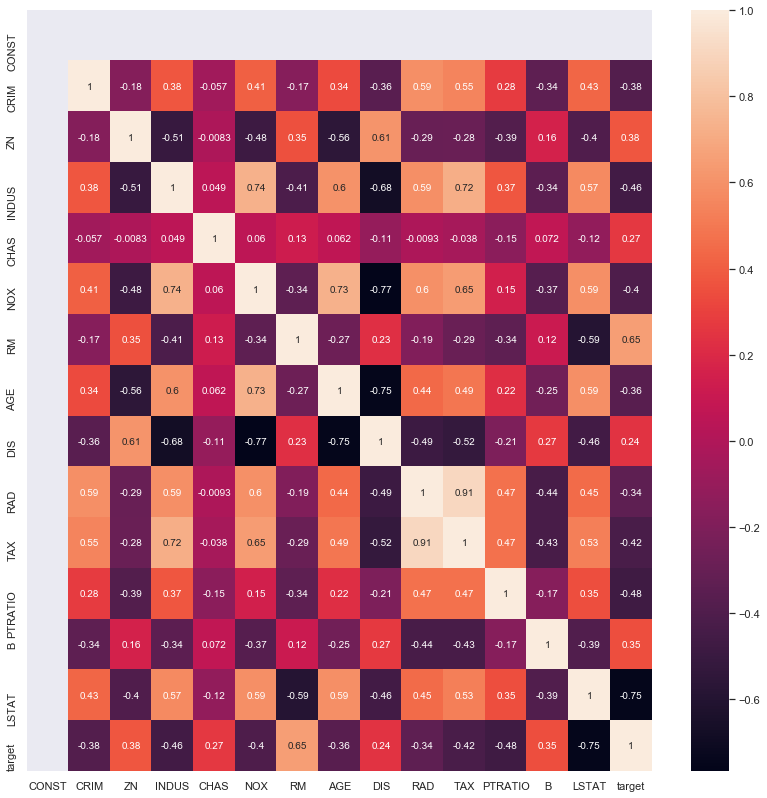

In [61]:
fig, ax = plt.subplots(figsize=(14,14)) 
sns.heatmap(train_df.corr(), annot=True, ax=ax);

Visually we can see lot of correlation among attribute(like DIS and INDUS) and some attribute being more predictive than other(looks like LSTAT is more predictive)

We can select feature based on correlation and predictivity. It is very important activity to make sure features are uncorrelated. Once can use PCA, ICA, dimentionality reduction, manifold learning to create uncorrelated features.

We can go head and pick the feature based on correlation and predictivity but
but let's go head and do learn ridge regression to take care of correlation among features.

## Let's build design matrix X containing observations along the rows

In [62]:
train_df.columns

Index(['CONST', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
       'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')

In [63]:
# We are doing random selection
selected_feature =['CONST', 'CRIM', 'INDUS', 'NOX', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT']
X_train = train_df[selected_feature].values
y_train = train_df['target'].values
X_valid = valid_df[selected_feature].values
y_valid = valid_df['target'].values.reshape((-1,1))
X_test =  test_df[selected_feature].values
y_test = test_df['target'].values.reshape((-1,1))
train_df.head()

,CONST,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
75,1.0,0.09512,0.0,12.83,0.0,0.437,6.286,45.0,4.5026,5.0,398.0,18.7,383.23,8.94,21.4
142,1.0,3.32105,0.0,19.58,1.0,0.871,5.403,100.0,1.3216,5.0,403.0,14.7,396.90,26.82,13.4
47,1.0,0.22927,0.0,6.91,0.0,0.448,6.030,85.5,5.6894,3.0,233.0,17.9,392.74,18.80,16.6
46,1.0,0.18836,0.0,6.91,0.0,0.448,5.786,33.3,5.1004,3.0,233.0,17.9,396.90,14.15,20.0
70,1.0,0.08826,0.0,10.81,0.0,0.413,6.417,6.6,5.2873,4.0,305.0,19.2,383.73,6.72,24.2


In [64]:
X_train[0:3,:], y_train[0:3] 

(array([[1.00000e+00, 9.51200e-02, 1.28300e+01, 4.37000e-01, 4.50260e+00,
         5.00000e+00, 3.98000e+02, 1.87000e+01, 3.83230e+02, 8.94000e+00],
        [1.00000e+00, 3.32105e+00, 1.95800e+01, 8.71000e-01, 1.32160e+00,
         5.00000e+00, 4.03000e+02, 1.47000e+01, 3.96900e+02, 2.68200e+01],
        [1.00000e+00, 2.29270e-01, 6.91000e+00, 4.48000e-01, 5.68940e+00,
         3.00000e+00, 2.33000e+02, 1.79000e+01, 3.92740e+02, 1.88000e+01]]),
 array([21.4, 13.4, 16.6]))

Solution of ridge regression is given by
$$\hat{w}_{ridge} = (\lambda I_D + X^TX)^{-1}X^T y$$


## Let's build a computational graph to find $\hat{w}_{ridge}$ 

# Creating a place holder of y. This represents the  vector containing all the y_i values

In [67]:
X = tf.compat.v1.placeholder(tf.float32, shape= X_train.shape, name='input_training_features')
y = tf.compat.v1.placeholder(tf.float32, shape = y_train.shape, name = 'y_i')
l = tf.compat.v1.placeholder(tf.float32, shape= [], name='regularization_weight')

In [68]:
X.shape, y.shape, l.shape

(TensorShape([303, 10]), TensorShape([303]), TensorShape([]))

In [69]:
y_train.shape

(303,)

## build ridge formula(computation)
first

$\lambda I_D + X^TX$

In [70]:
temp = tf.multiply(l, tf.eye(X_train.shape[1])) + tf.matmul(tf.transpose(X), X)

In [71]:
temp.shape

TensorShape([10, 10])

# Code to build
$(\lambda I_D + X^TX)^{-1} X^T$

Note that temp already has $\lambda I_D + X^TX$

Hint: search for how to represent matrix inverse 

In [72]:
temp_ridge = tf.matmul(tf.linalg.inv(temp), tf.transpose(X))
print(temp_ridge.shape)

(10, 303)


In [73]:
ridge_weights = tf.matmul(temp_ridge, tf.expand_dims(y,1))
print(ridge_weights.shape)

(10, 1)


## Let's run our computation graph, feeding actual data
<font color = 'green'>Note the feed_dict argument. We provide the actual data so that required graph dependency is statisfied </font>

# 1-d  grid of $\lambda$ values 

In [74]:
lambdas = [1e-20, 1e-10, 1e-5, 1e-4, 1e-3,1e-1, 1, 5.0, 10, 50, 100]
print(lambdas)
print(type(lambdas[0]))

[1e-20, 1e-10, 1e-05, 0.0001, 0.001, 0.1, 1, 5.0, 10, 50, 100]
<class 'float'>


# Building a pandas dataframe to store $\lambda$ and learned weights

In [75]:
ind =['lambda_{}'.format(la) for la in lambdas]
column_names = ['lambda', 'mse']+ ['w_{}'.format(i) for i in range(X_train.shape[1])]
print(ind)
print(column_names)
coeff_matrix = pd.DataFrame(index=ind, columns=column_names, dtype=np.float32)

['lambda_1e-20', 'lambda_1e-10', 'lambda_1e-05', 'lambda_0.0001', 'lambda_0.001', 'lambda_0.1', 'lambda_1', 'lambda_5.0', 'lambda_10', 'lambda_50', 'lambda_100']
['lambda', 'mse', 'w_0', 'w_1', 'w_2', 'w_3', 'w_4', 'w_5', 'w_6', 'w_7', 'w_8', 'w_9']


In [76]:
coeff_matrix.dtypes

lambda    float32
mse       float32
w_0       float32
w_1       float32
w_2       float32
w_3       float32
w_4       float32
w_5       float32
w_6       float32
w_7       float32
w_8       float32
w_9       float32
dtype: object

In [77]:
coeff_matrix.head()
# we haven't filled values in different columns.  NaN is ok

,lambda,mse,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9
lambda_1e-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lambda_1e-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lambda_1e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lambda_0.0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lambda_0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We used accuracy as a metric to measure the model performance.

But how to measure regression model performance for various value of $\lambda$?

For linear model we can calculate the MSE (mean square error)

In [78]:
with tf.compat.v1.Session() as sess:
    for i, reg in enumerate(lambdas):
        # running the graph and feeding actual data
        ridge_weight_value = sess.run(ridge_weights, feed_dict={X:X_train, y:y_train, l:reg})
        # Let's evaluate the performance using MSE on y_valid, y_valid_prediction data
        #print(ridge_weight_value)
        y_valid_pred= np.dot(X_valid, ridge_weight_value)
        # See how we can evaluate l_2 norm in numpy
        mse = (np.linalg.norm(y_valid - y_valid_pred ,ord=2)/(len(y_valid)))**2
        coeff_matrix.iloc[i, 0] = reg
        coeff_matrix.iloc[i, 1] = mse
        print(mse)
        coeff_matrix.iloc[i, 2:] = ridge_weight_value.T
    
    

0.34998807572855023
0.34998807572855023
0.35001998490360053
0.3500320146191408
0.3501987943543213
0.36832670876531276
0.4672005686689108
0.6005357778094117
0.6584680636799923
0.7426993188969306
0.75871045027108


In [79]:
y_valid.shape, y_valid_pred.shape, ridge_weight_value.shape, X_valid.shape

((101, 1), (101, 1), (10, 1), (101, 10))

In [80]:
coeff_matrix

,lambda,mse,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9
lambda_1e-20,1.000000e-20,0.349988,66.800598,-0.119067,-0.095517,-14.259823,-1.136989,0.327323,-0.005428,-1.329354,0.008818,-0.795561
lambda_1e-10,1.000000e-10,0.349988,66.800598,-0.119067,-0.095517,-14.259823,-1.136989,0.327323,-0.005428,-1.329354,0.008818,-0.795561
lambda_1e-05,1.000000e-05,0.350020,66.798393,-0.119066,-0.095501,-14.259111,-1.136918,0.327317,-0.005428,-1.329346,0.008818,-0.795562
lambda_0.0001,1.000000e-04,0.350032,66.791031,-0.119073,-0.095526,-14.252726,-1.136734,0.327282,-0.005428,-1.329154,0.008820,-0.795585
lambda_0.001,1.000000e-03,0.350199,66.720276,-0.119046,-0.095797,-14.189539,-1.134934,0.326934,-0.005420,-1.327543,0.008834,-0.795763
lambda_0.1,1.000000e-01,0.368327,60.264275,-0.116656,-0.118946,-8.706156,-0.975896,0.294909,-0.004668,-1.177223,0.010155,-0.811589
lambda_1,1.000000e+00,0.467201,36.523911,-0.108813,-0.180765,6.807191,-0.444945,0.170481,-0.000625,-0.560580,0.016674,-0.848738
lambda_5.0,5.000000e+00,0.600536,16.710842,-0.104708,-0.173658,8.076604,-0.136214,0.049994,0.005964,0.113358,0.026292,-0.826706
lambda_10,1.000000e+01,0.658468,10.372984,-0.103985,-0.157511,5.750194,-0.067889,0.007687,0.008829,0.364938,0.030372,-0.806834
lambda_50,5.000000e+01,0.742699,2.632616,-0.103736,-0.129799,1.631819,0.011586,-0.044325,0.012738,0.675513,0.036101,-0.772188


## Note how weights are decreasing as lambda increases in the bottom part for $w_i$

based on minimum mse pick corresponding weight vector to evalue mse on test set

In [81]:
# Selecting the index name that has minumum value of mse in corresponding row
selected_index = 'lambda_1e-05'

## See what would have happened if you choose the average of y_valid for prediction

In [82]:
mean_val = np.mean(y_valid, axis=0)
print(mean_val)

[25.33465347]


# This would have been our MSE in this base scenario

In [83]:
np.linalg.norm(y_valid -mean_val, ord=2)**2/len(y_valid)

91.37572983040876

# Let see how well we did on truly unseen data(never touched during building model)

In [84]:
selected_weights =  coeff_matrix.loc[selected_index,'w_0':].values.reshape((-1,1))

In [85]:
y_test_pred= np.dot(X_test, selected_weights)
print(y_test_pred.shape, y_test.shape)
print(type(y_test_pred), type(y_test))
test_mse = np.linalg.norm(y_test - y_test_pred ,ord=2)**2/(len(y_test))

(102, 1) (102, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [86]:
test_mse

18.235822804922364

# See what we get if we used sklearn

In [87]:
from sklearn.linear_model import Ridge
regressor = Ridge(alpha = [1e-05], normalize = False)
regressor.fit(X_train, y_train)
y_pred = np.array([regressor.predict(X_test)]).T
test_mse = np.linalg.norm(y_test - y_pred ,ord=2)**2/(len(y_test))
print(test_mse)

18.237174810027668


# Also one can see how good is  the linear model by analysing the error on training data. Error $\epsilon_i$ should be normally distributed

In [88]:
from statsmodels.graphics.gofplots import qqplot

In [89]:
y_train_pred= np.dot(X_train, coeff_matrix.loc[selected_index, 'w_0':].values.reshape((-1,1)))

In [90]:
error = y_train_pred - y_train

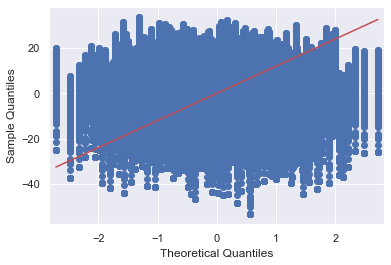

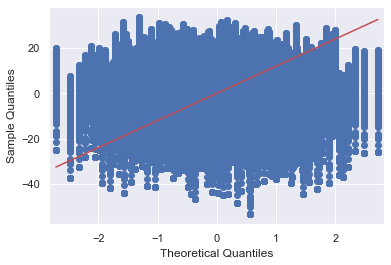

In [91]:
qqplot(error, line='s')
# looks line not a great fit